In [112]:
import glob
import math
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

traffic_path = '../../SmartCity-master/traffic\\'
daily_folder = "daily"
separator = ';'
weather_separator = ','
date_column = 'Dátum'
weather_date_column = 'datum'


def read_all_weather():
    path = "D:/Szakdolgozat/SmartCity-master/weather/Janostol/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=weather_separator, index_col=None, header=0))

    return weather_convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))


def read_all_traffic_daily():
    path = "D:/Szakdolgozat/SmartCity-master/traffic/AP1/hourly/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=separator, index_col=None, header=0))

    return convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))


def convert_to_date(data):
    data[date_column] = pd.to_datetime(data[date_column]).apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    return data

def weather_convert_to_date(data):
    data[weather_date_column] = pd.to_datetime(data[weather_date_column]).apply(lambda x: x.replace(second=0, microsecond=0))
    data[weather_date_column] = data[weather_date_column].apply(lambda x: x.replace(minute= (math.floor(x.minute / 10) * 10)))
    return data


In [122]:
wdf = read_all_weather()
wdf[weather_date_column] = wdf[weather_date_column].dt.date
wdf = wdf[(wdf[weather_date_column] >= pd.to_datetime("2020-02-22 22:00:00")) & (wdf[weather_date_column] <= pd.to_datetime("2020-09-09 09:10:00"))]
wdf.rename(columns={'datum': 'Dátum'}, inplace=True)
wdf = wdf[wdf['telepules'] == 'k']
wdf = wdf.drop(wdf[wdf['atlaghom.'] == "-"].index)
wdf['atlaghom.'] = wdf['atlaghom.'].astype(float)
wdf = wdf.groupby(date_column, as_index=False)['atlaghom.'].mean()
wdf

,Dátum,atlaghom.
0,2020-02-22,4.197222
1,2020-02-23,7.968056
2,2020-02-24,8.260417
3,2020-02-25,8.598611
4,2020-02-26,7.462500
...,...,...
196,2020-09-05,20.062500
197,2020-09-06,22.062500
198,2020-09-07,22.227778
199,2020-09-08,18.440972


In [123]:
df = read_all_traffic_daily()

df.rename(columns={'Irány 0 - Autók számossága': 'Belváros felé - Autók számossága',
                   'Irány 1 - Autók számossága': 'Újszeged felé - Autók számossága',}, inplace=True)

df = df.sort_values('Dátum', ascending=True)
df['Hour'] = df[date_column].dt.hour
df[date_column] = df[date_column].dt.date
df = pd.merge(df, wdf[['Dátum', 'atlaghom.']], on=['Dátum'], how='inner')
df.head(50)

,Dátum,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,Hour,atlaghom.
0,2020-02-22,3,7,1,0,3,1,0,0,0,0,22,4.197222
1,2020-02-22,27,31,5,1,2,1,1,0,1,0,23,4.197222
2,2020-02-23,87,142,6,10,10,12,0,1,0,0,0,7.968056
3,2020-02-23,60,71,4,8,7,14,0,0,0,0,1,7.968056
4,2020-02-23,55,72,2,7,4,8,3,0,0,0,2,7.968056
5,2020-02-23,46,53,0,6,7,13,2,1,0,2,3,7.968056
6,2020-02-23,33,31,2,6,1,3,0,3,1,1,4,7.968056
7,2020-02-23,364,250,20,23,36,20,16,20,4,11,8,7.968056
8,2020-02-23,551,375,40,35,168,44,19,19,8,7,9,7.968056
9,2020-02-23,591,461,33,33,121,22,9,24,6,5,10,7.968056


In [124]:
df.sort_values('Belváros felé - Autók számossága', ascending=False).head(50)

,Dátum,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,Hour,atlaghom.
4393,2020-08-28,1078,614,104,77,210,35,56,45,16,10,8,22.764583
2472,2020-06-09,1061,477,110,62,183,19,28,24,6,8,7,20.092806
2520,2020-06-11,1053,520,101,64,223,10,29,13,10,5,7,17.340845
4488,2020-09-01,1047,627,119,56,152,8,48,71,18,11,7,17.997222
2616,2020-06-15,1044,462,148,84,149,12,45,44,14,8,7,19.864583
326,2020-03-09,1039,644,97,81,222,35,59,56,16,19,7,6.084028
4394,2020-08-28,1035,565,144,89,109,23,62,39,15,9,9,22.764583
3840,2020-08-05,1030,578,101,42,98,11,55,45,14,7,7,21.238889
2712,2020-06-19,1029,526,114,74,162,17,50,42,8,10,7,19.819580
2783,2020-06-22,1027,412,42,34,43,3,42,40,18,12,6,19.642361


In [125]:
df['DayOfWeek'] = pd.DatetimeIndex(df[date_column]).dayofweek

df['Monday'] = df['DayOfWeek'] == 0
df['Tuesday'] = df['DayOfWeek'] == 1
df['Wednesday'] = df['DayOfWeek'] == 2
df['Thursday'] = df['DayOfWeek'] == 3
df['Friday'] = df['DayOfWeek'] == 4
df['Saturday'] = df['DayOfWeek'] == 5
df['Sunday'] = df['DayOfWeek'] == 6

df['Curfew'] = (df[date_column] >= pd.to_datetime("2020-03-28")) & (df[date_column] <= pd.to_datetime("2020-05-04"))
df['Holiday'] = (df[date_column] == pd.to_datetime("2020-03-15")) | (df[date_column] == pd.to_datetime("2020-04-10")) | (df[date_column] == pd.to_datetime("2020-04-12")) | (df[date_column] == pd.to_datetime("2020-04-13")) | (df[date_column] == pd.to_datetime("2020-05-01")) | (df[date_column] == pd.to_datetime("2020-05-31")) | (df[date_column] == pd.to_datetime("2020-06-01")) | (df[date_column] == pd.to_datetime("2020-08-20")) | (df[date_column] == pd.to_datetime("2020-10-23")) | (df[date_column] == pd.to_datetime("2020-11-01"))
df['Weekend'] = (pd.DatetimeIndex(df[date_column]).dayofweek >= 5)

df['Education'] =  ((df[date_column] >= pd.to_datetime("2020-01-01")) & (df[date_column] <= pd.to_datetime("2020-03-13"))) | ((df[date_column] >= pd.to_datetime("2020-09-01")) & (df[date_column] <= pd.to_datetime("2020-10-22"))) | ((df[date_column] >= pd.to_datetime("2020-11-02")) & (df[date_column] <= pd.to_datetime("2020-12-18")))
df['Education'] =  (df['Education'] == True) & (df['Weekend'] == False) & (df['Holiday'] == False)

df['DigitalEducation'] = ((df[date_column] >= pd.to_datetime("2020-03-16")) & (df[date_column] <= pd.to_datetime("2020-04-08"))) | (df[date_column] >= pd.to_datetime("2020-04-15")) & (df[date_column] <= pd.to_datetime("2020-06-16"))
df['DigitalEducation'] = (df['DigitalEducation'] == True) & (df['Weekend'] == False)

In [126]:
df.head(50)

,Dátum,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,...,Wednesday,Thursday,Friday,Saturday,Sunday,Curfew,Holiday,Weekend,Education,DigitalEducation
0,2020-02-22,3,7,1,0,3,1,0,0,0,...,False,False,False,True,False,False,False,True,False,False
1,2020-02-22,27,31,5,1,2,1,1,0,1,...,False,False,False,True,False,False,False,True,False,False
2,2020-02-23,87,142,6,10,10,12,0,1,0,...,False,False,False,False,True,False,False,True,False,False
3,2020-02-23,60,71,4,8,7,14,0,0,0,...,False,False,False,False,True,False,False,True,False,False
4,2020-02-23,55,72,2,7,4,8,3,0,0,...,False,False,False,False,True,False,False,True,False,False
5,2020-02-23,46,53,0,6,7,13,2,1,0,...,False,False,False,False,True,False,False,True,False,False
6,2020-02-23,33,31,2,6,1,3,0,3,1,...,False,False,False,False,True,False,False,True,False,False
7,2020-02-23,364,250,20,23,36,20,16,20,4,...,False,False,False,False,True,False,False,True,False,False
8,2020-02-23,551,375,40,35,168,44,19,19,8,...,False,False,False,False,True,False,False,True,False,False
9,2020-02-23,591,461,33,33,121,22,9,24,6,...,False,False,False,False,True,False,False,True,False,False


In [127]:
df.corr()['Belváros felé - Autók számossága'].sort_values

<bound method Series.sort_values of Belváros felé - Autók számossága    1.000000
Újszeged felé - Autók számossága    0.876588
Irány 0 - Biciklisek számossága     0.726688
Irány 1 - Biciklisek számossága     0.744743
Irány 0 - Gyalogosok számossága     0.788832
Irány 1 - Gyalogosok számossága     0.631089
Irány 0 - Buszok számossága         0.707152
Irány 1 - Buszok számossága         0.698455
Irány 0 - Trolik számossága         0.753622
Irány 1 - Trolik számossága         0.683715
Hour                                0.196616
atlaghom.                           0.129020
DayOfWeek                          -0.132141
Monday                              0.024340
Tuesday                             0.044705
Wednesday                           0.041577
Thursday                            0.045955
Friday                              0.068767
Saturday                           -0.065068
Sunday                             -0.165193
Curfew                             -0.200154
Holiday            

<AxesSubplot:xlabel='Belváros felé - Autók számossága', ylabel='Irány 0 - Gyalogosok számossága'>

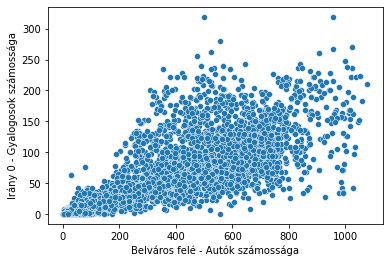

In [128]:
sns.scatterplot(x='Belváros felé - Autók számossága', y='Irány 0 - Gyalogosok számossága', data=df)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Belváros felé - Autók számossága'>

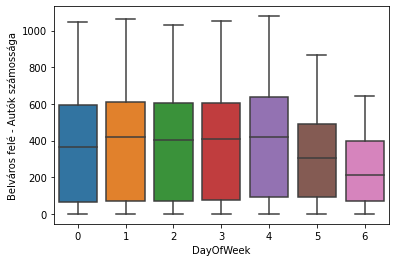

In [129]:
sns.boxplot(x='DayOfWeek', y='Belváros felé - Autók számossága', data=df)

<AxesSubplot:xlabel='Hour', ylabel='Belváros felé - Autók számossága'>

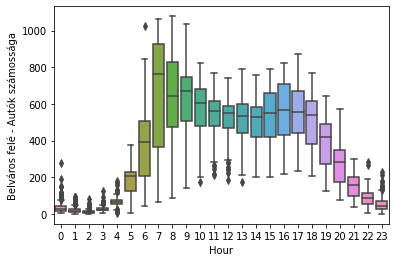

In [130]:
sns.boxplot(x='Hour', y='Belváros felé - Autók számossága', data=df)

In [223]:
X = df[['atlaghom.', 'Hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values

y = df['Irány 0 - Gyalogosok számossága'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [224]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [225]:
model = Sequential()

model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [226]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=3000, callbacks=[early_stop])

Train on 3278 samples, validate on 1405 samples
Epoch 1/3000
3278/3278 [==============================] - 0s 126us/sample - loss: 6322.6461 - val_loss: 5148.1939
Epoch 2/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 3266.3092 - val_loss: 2920.5669
Epoch 3/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2676.2067 - val_loss: 2657.9455
Epoch 4/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2497.1630 - val_loss: 2545.2880
Epoch 5/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2407.2289 - val_loss: 2487.6244
Epoch 6/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2353.1948 - val_loss: 2435.5138
Epoch 7/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2294.8344 - val_loss: 2375.0004
Epoch 8/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 2223.4357 - val_loss: 2288.2846
Epoch 9/3000
3278/3278 [=======================

3278/3278 [==============================] - 0s 26us/sample - loss: 659.6006 - val_loss: 757.5078
Epoch 74/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 645.5623 - val_loss: 785.9138
Epoch 75/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 651.5840 - val_loss: 743.7241
Epoch 76/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 649.7647 - val_loss: 749.5615
Epoch 77/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 635.6420 - val_loss: 755.8786
Epoch 78/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 664.4032 - val_loss: 766.0177
Epoch 79/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 644.4603 - val_loss: 760.6673
Epoch 80/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 652.0862 - val_loss: 761.7410
Epoch 81/3000
3278/3278 [==============================] - 0s 26us/sample - loss: 643.5280 - val_loss: 741.9020
Epoch 

<AxesSubplot:>

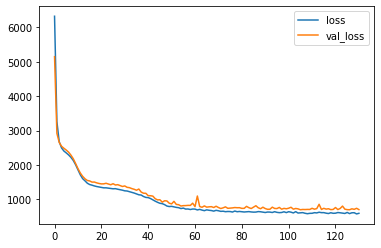

In [227]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [228]:
predictions = model.predict(X_test)

In [229]:
#sns.distplot((y_test-predictions),bins=50);

In [230]:
np.sqrt(mean_squared_error(y_test, predictions))

26.586565186274797

In [231]:
mean_absolute_error(y_test, predictions)

17.24032726958129

In [232]:
explained_variance_score(y_test, predictions)

0.77006348778487

In [233]:
test_predictions = model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(1405,))
pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

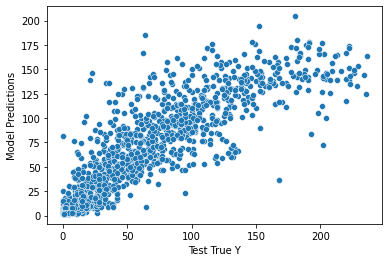

In [234]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [235]:
#X = df[['Hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values

new_data = [[10,7,True,False,False,False,False,False,False,False,False,False,False,False]]
new_data = scaler.transform(new_data)
model.predict(new_data)

model.predict(new_data)

array([[103.41263]], dtype=float32)

In [236]:
df.describe()

,Belváros felé - Autók számossága,Újszeged felé - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,Hour,atlaghom.,DayOfWeek
count,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.000000,4683.00000,4683.000000,4683.000000
mean,349.325005,342.434764,51.872518,56.638266,59.357036,21.628016,20.143711,24.079436,6.371343,6.907751,11.50032,16.616218,2.964126
std,266.047392,269.339818,43.068335,48.812269,55.000336,20.380092,18.982030,18.435906,5.630955,5.646540,6.92877,6.425172,1.987035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.038889,0.000000
25%,75.000000,71.000000,15.000000,13.000000,11.000000,5.000000,7.000000,13.000000,2.000000,2.000000,5.00000,12.106944,1.000000
50%,353.000000,332.000000,45.000000,47.000000,46.000000,16.000000,17.000000,22.000000,5.000000,6.000000,12.00000,17.572917,3.000000
75%,571.000000,560.000000,78.000000,89.000000,94.000000,33.000000,28.000000,33.000000,9.000000,10.000000,18.00000,21.922143,5.000000
max,1078.000000,1075.000000,299.000000,277.000000,319.000000,122.000000,199.000000,156.000000,36.000000,46.000000,23.00000,27.287500,6.000000


In [237]:
model.save('hour_Szeged_fele_gyalogosok.h5')
joblib.dump(scaler, 'hour_Szeged_fele_gyalogosok.pkl') 

['hour_Szeged_fele_gyalogosok.pkl']